In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

import torch.optim as optim
import torchvision.models as models

import PIL.Image as Image

In [13]:
image_size = (224,224)
data_transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [3]:
train_data=dset.ImageFolder(root="data/train",transform=data_transform)
# 数据集长度
totallen = len(train_data)
print('train data length:',totallen)

train data length: 11866


In [4]:
trainlen = int(totallen*0.7)
vallen = totallen - trainlen
train_db,val_db=torch.utils.data.random_split(train_data,[trainlen,vallen])
print('train:',len(train_db),'validation:',len(val_db))

train: 8306 validation: 3560


In [5]:
# batch size
bs=32
# 训练集
train_loader=torch.utils.data.DataLoader(train_db,batch_size=bs, shuffle=True,num_workers=2)
# 验证集
val_loader=torch.utils.data.DataLoader(val_db,batch_size=bs, shuffle=True,num_workers=2)

In [6]:
def get_num_correct(out, labels):
    return out.argmax(dim=1).eq(labels).sum().item()

In [7]:
batch = next(iter(train_loader))

In [8]:
resnet50 = models.resnet50(pretrained=True)

In [9]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
train_data.classes

['hazardous_waste_dry_battery',
 'hazardous_waste_expired_drugs',
 'hazardous_waste_ointment',
 'kitchen_waste_bone',
 'kitchen_waste_eggshell',
 'kitchen_waste_fish_bone',
 'kitchen_waste_fruit_peel',
 'kitchen_waste_meal',
 'kitchen_waste_pulp',
 'kitchen_waste_tea',
 'kitchen_waste_vegetable',
 'other_garbage_bamboo_chopsticks',
 'other_garbage_cigarette',
 'other_garbage_fast_food_box',
 'other_garbage_flowerpot',
 'other_garbage_soiled_plastic',
 'other_garbage_toothpick',
 'recyclables_anvil',
 'recyclables_bag',
 'recyclables_bottle',
 'recyclables_can',
 'recyclables_cardboard',
 'recyclables_cosmetic_bottles',
 'recyclables_drink_bottle',
 'recyclables_edible_oil_barrel',
 'recyclables_glass_cup',
 'recyclables_metal_food_cans',
 'recyclables_old_clothes',
 'recyclables_paper_bags',
 'recyclables_pillow',
 'recyclables_plastic_bowl',
 'recyclables_plastic_hanger',
 'recyclables_plug_wire',
 'recyclables_plush_toys',
 'recyclables_pot',
 'recyclables_powerbank',
 'recyclables_s

In [11]:
model = resnet50
n_classes = len(train_data.classes)
model.fc = nn.Linear(2048, n_classes)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
import torch.nn.init as init

for name, module in model._modules.items():
    if(name=='fc'):
        # print(module.weight.shape)
        init.kaiming_uniform_(module.weight, a=0, mode='fan_in')

In [14]:
device=torch.device("cpu")

In [15]:
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)
epoch_num = 5
model = model.to(device)
for epoch in range(epoch_num):
    total_loss=0
    total_correct=0
    val_correct=0
    for batch in train_loader:#GetBatch
        images,labels=batch
        images = images.to(device)
        labels = labels.to(device)
        outs=model(images)#PassBatch
        loss=F.cross_entropy(outs,labels)#CalculateLoss
        optimizer.zero_grad()
        loss.backward()#CalculateGradients
        optimizer.step()#UpdateWeights
        total_loss+=loss.item()
        total_correct+=get_num_correct(outs,labels)
    for batch in val_loader:
        images,labels=batch
        images = images.to(device)
        labels = labels.to(device)
        outs=model(images)
        val_correct+=get_num_correct(outs,labels)
    print("loss:",total_loss,"train_correct:",total_correct/trainlen, "val_correct:",val_correct/vallen)

G:\anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 331.0912456214428 train_correct: 0.6851673489044064 val_correct: 0.802247191011236
loss: 102.6309883967042 train_correct: 0.8962196002889478 val_correct: 0.8328651685393258
loss: 49.35299431160092 train_correct: 0.9588249458222972 val_correct: 0.8407303370786516
loss: 24.327850837260485 train_correct: 0.9839874789308933 val_correct: 0.8474719101123596
loss: 14.57629613019526 train_correct: 0.992655911389357 val_correct: 0.8539325842696629


In [16]:
torch.save(model, 'trash.pkl')

In [14]:
model = torch.load('trash.pkl')
model.eval()
filename = 'data/test/101.jpg'
input_image = Image.open(filename).convert('RGB')

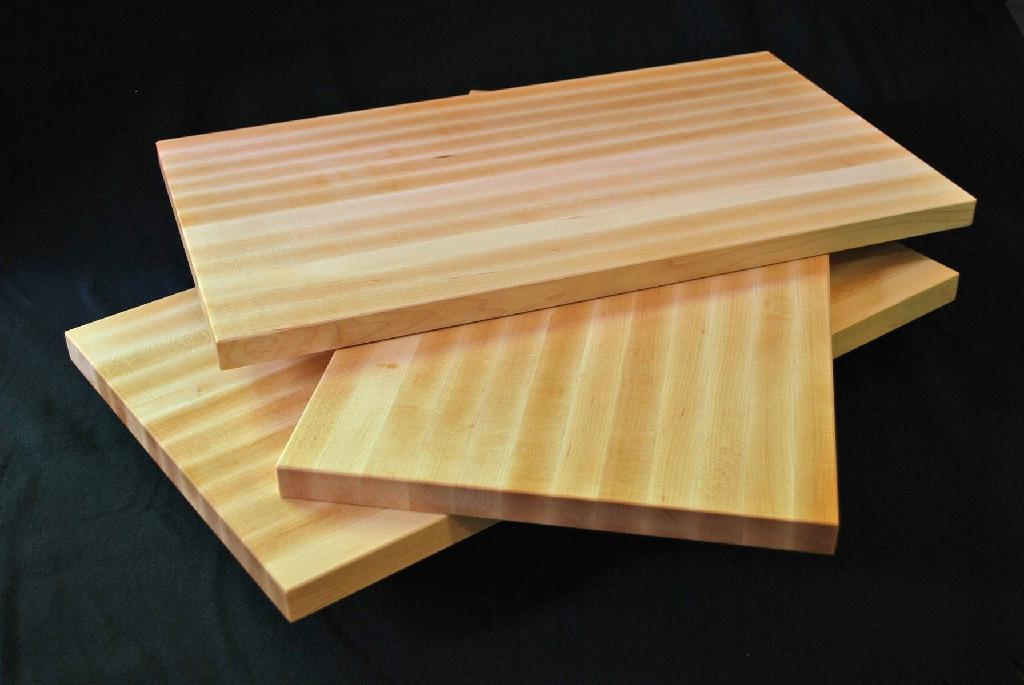

In [15]:
input_image

In [16]:
input_tensor = data_transform(input_image)
input_batch = input_tensor.unsqueeze(0) 

In [17]:
input_tensor.shape

torch.Size([3, 224, 224])

In [23]:
model.to('cpu')
with torch.no_grad():
    output = model(input_batch)
prob = F.softmax(output[0], dim=0)
indexs = torch.argsort(-prob)
topk = 1
a=['hazardous_waste_dry_battery',
 'hazardous_waste_expired_drugs',
 'hazardous_waste_ointment',
 'kitchen_waste_bone',
 'kitchen_waste_eggshell',
 'kitchen_waste_fish_bone',
 'kitchen_waste_fruit_peel',
 'kitchen_waste_meal',
 'kitchen_waste_pulp',
 'kitchen_waste_tea',
 'kitchen_waste_vegetable',
 'other_garbage_bamboo_chopsticks',
 'other_garbage_cigarette',
 'other_garbage_fast_food_box',
 'other_garbage_flowerpot',
 'other_garbage_soiled_plastic',
 'other_garbage_toothpick',
 'recyclables_anvil',
 'recyclables_bag',
 'recyclables_bottle',
 'recyclables_can',
 'recyclables_cardboard',
 'recyclables_cosmetic_bottles',
 'recyclables_drink_bottle',
 'recyclables_edible_oil_barrel',
 'recyclables_glass_cup',
 'recyclables_metal_food_cans',
 'recyclables_old_clothes',
 'recyclables_paper_bags',
 'recyclables_pillow',
 'recyclables_plastic_bowl',
 'recyclables_plastic_hanger',
 'recyclables_plug_wire',
 'recyclables_plush_toys',
 'recyclables_pot',
 'recyclables_powerbank',
 'recyclables_seasoning_bottle',
 'recyclables_shampoo_bottle',
 'recyclables_shoes',
 'recyclables_toys']
for i in range(topk):
    print("label:", a[indexs[i].item()], " prob: ", prob[indexs[i]])

label: recyclables_anvil  prob:  tensor(0.9955)
